In [3]:
import numpy as np
import jax
import jax.numpy as jnp
from  matplotlib import pyplot as plt





In [118]:
#TODO: think properly about inputs-outputs.

def rand_volume(shape, dimensions, radius):
    """Gets and prints the spreadsheet's header columns

    Parameters
    ----------
    shape : 3 x 1 array
        Dimensions of the volume, in number of elements
    dimensions: 3 x 1 array
        Dimensions of the volume, in units (e.g. Angst?)
    radius: float
        Radius of spherical object

    Returns
    -------
    vol
        the volume
    """
    
    Nx, Ny, Nz = shape
    vol = np.random.randn(Nx, Ny, Nz)
    
    Lx, Ly, Lz = dimensions
    coords_x = np.linspace(-Lx/2, Lx/2, Nx)
    coords_y = np.linspace(-Ly/2, Ly/2, Ny)
    coords_z = np.linspace(-Lz/2, Lz/2, Nz) 
    X, Y, Z = np.meshgrid(coords_x, coords_y, coords_z)
    
    print("AA")
    print(X.shape)
    
    mask = create_mask(X, Y, Z, radius)   
    
    return vol * mask

In [119]:
def create_mask(X,Y,Z, radius):    
    mask = np.ones(shape)
    r = np.sqrt(X**2 + Y**2 + Z**2)
    print(X.shape)
    print(radius)
    mask[r > radius] = 0
    return mask

In [120]:
#TODO: debug all this stuff

nx = 11
shape = nx * np.ones(3, dtype=np.int32)
length = 5
dimensions = 5 * np.ones(3)
radius = 2


v = rand_volume(shape, dimensions, radius)

AA
(11, 11, 11)
(11, 11, 11)
2


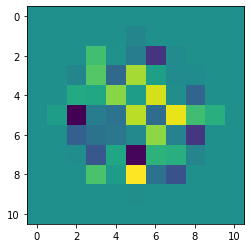

In [121]:
plt.imshow(v[:,:,5])

In [53]:
xx = 5 * np.ones(3)

In [55]:
x,y,z = xx

In [63]:
cx = np.linspace(-2,2,5)
cy = np.linspace(-10,10,6)

In [70]:
X,Y, Z = np.meshgrid(cx,cy,cy)

In [102]:
X = np.random.randn(4,4)

In [107]:
X[X < 0.5] = 100

In [108]:
X

array([[  1.54962035, 100.        , 100.        , 100.        ],
       [100.        , 100.        ,   0.80309254, 100.        ],
       [100.        , 100.        , 100.        , 100.        ],
       [100.        ,   1.01420095, 100.        , 100.        ]])